In [1]:
import numpy as np
from ptychoSampling.reconstruction.recons import BraggPtychoReconstructionT
from ptychoSampling.utils.utils import getRandomComplexArray
import matplotlib.pyplot as plt
import tensorflow as tf
from copy import deepcopy
from ptychoSampling.mabp.simulation import Simulation
import dill

W0925 14:06:37.410280 140661544752960 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/optimization.py:5: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Whether to reload existing simulation data (if available) or to create new data
reload_simulation = True

In [4]:
if reload_simulation:
    try:
        with open('simulation.pkl', 'rb') as f:
            sim = dill.load(f)
        with open('scan_grid_filtered.pkl', 'rb') as f:
            scan_grid_filtered = dill.load(f)
        with open('intensities_filtered.pkl', 'rb') as f:
            intensities_filtered = dill.load(f)
    except:
        sim = Simulation()
        scan_grid_filtered, intensities_filtered = sim.filterScanPositionsAndIntensities(threshold=1.0)
        
        names_items = {'simulation': sim, 
                       'scan_grid_filtered':scan_grid_filtered,
                       'intensities_filtered': intensities_filtered}
                       #'obj':obj, 
                       #'probe_3d':probe_3d, 
                       #'detector':detector}
        for name, item in names_items.items():
            with open(f'{name}.pkl', 'wb') as f:
                dill.dump(item, f)
else:
    sim = Simulation()
    scan_grid_filtered, intensities_filtered = sim.filterScanPositionsAndIntensities(threshold=1.0)

I0925 14:06:37.584599 140661544752960 simulation.py:122] Creating new detector.
I0925 14:06:37.585316 140661544752960 simulation.py:203] Creating new crystal cell.
I0925 14:06:39.045631 140661544752960 simulation.py:211] Adding x and z borders to crystal cell based on detector parameters.
I0925 14:06:39.051578 140661544752960 simulation.py:235] Creating new guassian, speckled, 2d probe.
W0925 14:06:39.052179 140661544752960 probe.py:83] If width_npix is supplied, then any supplied width_dist is ignored.
I0925 14:06:39.055747 140661544752960 simulation.py:241] Rotating and interpolating the 2d probe to generate the 3d probe.
W0925 14:06:39.137800 140661544752960 simulation.py:167] Adding zero padding to the object in the y-direction so that the overall object y-width covers the entirety of the feasible probe positions.
I0925 14:06:39.168017 140661544752960 simulation.py:188] creating new 2d scan grid based on object and probe shapes.
I0925 14:06:39.201351 140661544752960 simulation.py:1

# Starting the reconstruction with a random object guess

In [5]:
obj_guess = deepcopy(sim.obj)
obj_guess.array = getRandomComplexArray(shape=obj_guess.array.shape, phase_range=2*np.pi)

In [6]:
r = BraggPtychoReconstructionT(obj = obj_guess, 
                               probe=sim.probe_3d,
                               grid=scan_grid_filtered,
                               intensities=intensities_filtered,
                               batch_size=100,
                               n_validation=50,
                               obj_array_true=sim.obj.array)

I0925 14:07:17.626192 140661544752960 recons.py:493] initializing...
I0925 14:07:18.341092 140661544752960 recons.py:36] creating batches...
W0925 14:07:18.837472 140661544752960 deprecation.py:323] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:225: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
I0925 14:07:18.920374 140661544752960 recons.py:39] creating log...
I0925 14:07:18.921055 140661544752960 recons.py:496] attaching fwd model...
I0925 14:07:18.954765 140661544752960 forwardmodel_t.py:28] Creating obj views for the scan positions.
I0925 14:07:25.677743 140661544752960 forwardmodel_t.py:224] Creating the pha

In [7]:
r.run(max_iterations=10000, patience=200)

I0925 14:07:42.281826 140661544752960 recons.py:243] finalizing the data logger.
I0925 14:07:42.282702 140661544752960 datalogs_t.py:101] Initializing the log outputs...
W0925 14:07:42.290891 140661544752960 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:246: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

I0925 14:07:42.291635 140661544752960 recons.py:248] Initializing the session.
W0925 14:07:42.292303 140661544752960 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:249: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0925 14:07:44.379778 140661544752960 deprecation_wrapper.py:119] From /raid/home/skandel/code/ptychoSampling_v2/ptychoSampling/reconstruction/recons.py:250: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instea

       epoch  train_loss  validation_loss  validation_min   patience  obj_error
1          0    5.14e+06         2.37e+06        2.37e+06         50          1
401         10   3.41e+04   1.68e+04   1.68e+04         50      0.779
801         20   1.69e+04   8.13e+03   8.13e+03         50      0.558
1201         30   1.73e+04   7.84e+03   7.84e+03         50      0.541
1601         40   1.82e+04   7.88e+03   7.84e+03         50      0.541
2001         50   1.75e+04   7.95e+03   7.84e+03         50      0.533


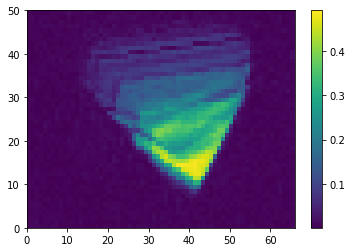

In [8]:
plt.pcolormesh(np.abs(r.obj.array[11]))
plt.colorbar()

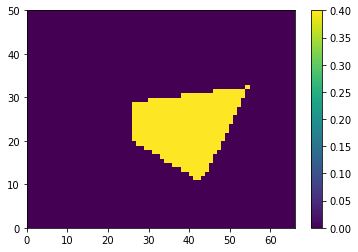

In [9]:
plt.pcolormesh(np.abs(sim.obj.array[11]))
plt.colorbar()